**RNN과 CNN을 사용해 시퀀스 처리하기**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import sys
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

# 파이썬 ≥3.5 필수
assert sys.version_info >= (3, 5)

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = 'google.colab' in sys.modules

# 텐서플로 ≥2.0 필수
assert tf.__version__ >= '2.0'
if not tf.config.list_physical_devices('GPU'):
    print('감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.')
    if IS_COLAB:
        print('런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.')

# 깔끔한 그래프 출력을 위해
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, f'{fig_id}.{fig_extension}')
    print(f'그림 저장 {fig_id}')
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 기본적인 RNN

## 데이터셋 생성

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # 웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)  # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [9]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

그림 저장 time_series_plot


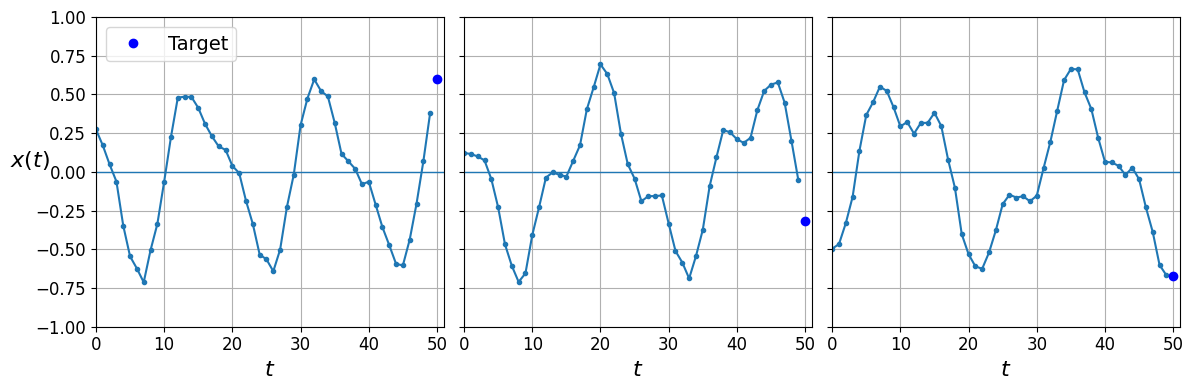

In [22]:
def plot_series(series, y=None, y_pred=None, x_label='$t$', y_label='$x(t)$', legend=True):
    plt.plot(series, '.-')
    if y is not None:
        plt.plot(n_steps, y, 'bo', label='Target')
    if y_pred is not None:
        plt.plot(n_steps, y_pred, 'rx', markersize=10, label='Prediction')
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc='upper left')


fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0], y_label=('$x(t)$' if col == 0 else None), legend=(col == 0))
save_fig('time_series_plot')
plt.show()

**노트**: 이 노트북에서 파란 점은 타깃을 나타내고 빨강 X 표시는 예측을 나타낸다.

## 기준 성능 계산하기

단순한 예측 (마지막 관측값을 사용해 예측한다):